In [50]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# Read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [52]:
len(words)

32033

In [53]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [54]:
# Build the dataset 
def build_dataset(words):
    block_size = 3 # How many characters to take to predict the next one
    X, Y = [], []
    
    for w in words:
    
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # Crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y
    
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [55]:
# --- Implmenting layers ---

In [56]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [71]:
# Neural net initilization

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [72]:
sum(p.nelement() for p in parameters) # Number of parameters in total

11897

In [73]:
for p in parameters:
    p.requires_grad = True

In [74]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [75]:
lri = []
lossi = []
stepi = []

In [76]:
for i in range(200000):

    # Mini-batch construct

    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass    
    
    # Hidden layer
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, C.shape[1] * 3) @ W1 + b1 ) # (32, 100)
    
    # Output layer
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
   

    # Backward pass
    for p in parameters: 
        p.grad = None # Restart gradient
    loss.backward()
    

    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

#print(loss.item())

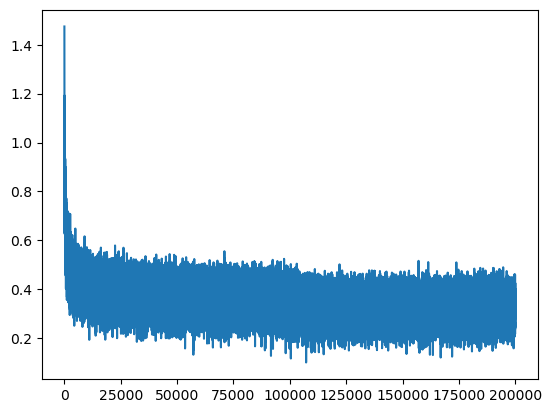

In [77]:
plt.plot(stepi, lossi)
plt.show()

In [78]:
# Validation for all training

emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, C.shape[1] * 3) @ W1 + b1 ) # (32, 100)
    
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1245, grad_fn=<NllLossBackward0>)

In [79]:
# Validation for all dev values

emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, C.shape[1] * 3) @ W1 + b1 ) # (32, 100)
    
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1751, grad_fn=<NllLossBackward0>)

In [91]:
# Validation for all test values

emb = C[Xte] # [32, 3, 2]
h = torch.tanh(emb.view(-1, C.shape[1] * 3) @ W1 + b1 ) # (32, 100)
    
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1697, grad_fn=<NllLossBackward0>)

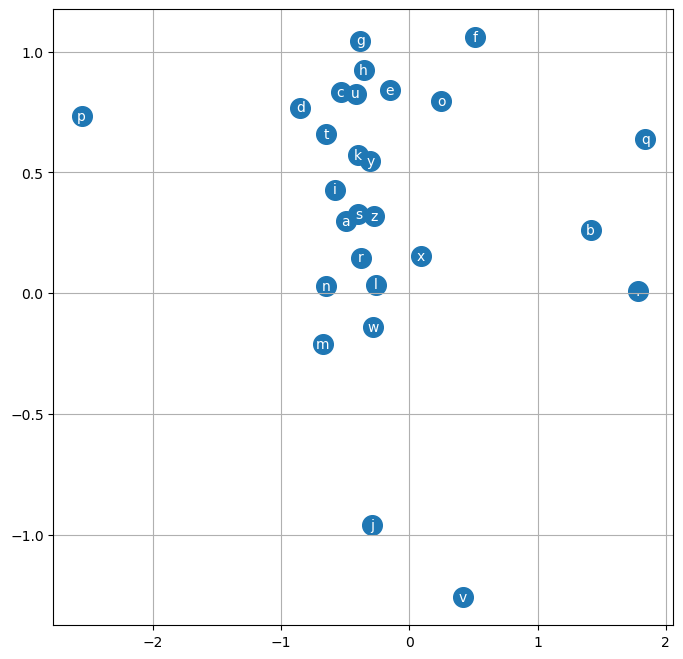

In [81]:
# Visualizing character embedding 
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.show()

In [92]:
# Sample from the model
block_size = 3

for _ in range(10):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

lizan.
emberne.
ocilandi.
jasmirion.
kha.
chaler.
syah.
maksie.
rul.
perelin.
